# The Race Around The Netherlands
Part 2: webscraping the leaderboards

There are 4 editions of the race. The leaderboard with the check-point timings can be found here:

2018: https://ratn2018.legendstracking.com/#

2019: https://ratn2019.legendstracking.com/# 

2020: https://ratn2020.legendstracking.com/#

2021: https://ratn2021.legendstracking.com/# AND/OR
https://www.dotwatcher.cc/race/race-around-the-netherlands-2020?reverse=true

Unfortunately, the info I need is in Javascript and I need to click a button for the table to become visible. Therefore I can not just use BeautifulSoup. I will first have to click the button using Selenium, and - as I'm working in Chrome - the Chrome webdriver. 
- selenium: https://pypi.org/project/selenium/
- chrome webdriver: https://chromedriver.chromium.org/getting-started

In [2]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import regex as re
import datetime

In [3]:
#for scraping java
import selenium
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
# from selenium.webdriver.support.ui import WebDriverWait
# from selenium.webdriver.support.expected_conditions import presence_of_element_located
# import time
# import sys

## RATN 2018

In [ ]:
url = 'https://ratn2018.legendstracking.com/#'

#set that you want to run the chrome headless (behind the scenes, in the background)
chrome_options = Options()
chrome_options.add_argument("--headless")

#insert absolute path of chrome driver
driver = webdriver.Chrome('C:/Users/jetsa/chromedriver.exe', options = chrome_options)
driver.get(url)

#### Click the right button
The buttons are placed here in the code:

-- nav tabs -->

li id="leaderboard-icon" class="active">

I search for the button using the tab-id: "leaderboard-icon"

In [ ]:
# Find and click the right button, using the tab's id
button = driver.find_element(By.ID, "leaderboard-icon")
button.click()

In [ ]:
#From here on you can start using BS4. This will now also find the html=code of the table that became visible by clicking the button.
source = driver.page_source

#close the webdriver that runs in the background
driver.close()

soup = BeautifulSoup(source, 'html')
print(soup.prettify())

#### Find the right tables
There are 4 tables in the code.

- The first one contains nothing of interest

- The second one contains nothing of interest either

- The third one contains the headers (Start, Timing 1, Timing 2 etc) and timings of solo riders

- The fourth one contains the headers (Start, Timing 1, Timing 2 etc) and timings of rider-pairs

I'll start with the solo riders.

In [ ]:
#pick the second table. This one contains information about the soloriders.
table_solo = soup.find_all('table')[2]
table_solo

We have another challenge:
If you text.split().strip() the columns, there is no good character to do so. It becomes a horrible mess: double names ending up in timeslots etc.
Also, you cannot isolate the icon that displays the sex. 

Solutions: convert each table row into one long string. This way you can both grab the description of the icon (mars or venus) and split the columns on the closing td.  

In [ ]:
rows_solo = table_solo.findChildren('tr')

#convert each elements into a string to prevent a horrible mess
string_rows = []

for i in rows_solo:
    i = str(i)
    string_rows.append(i)
print(string_rows[7])

In [ ]:
#convert the string+rows into a dataframe. Name the column "riders"
solo_riders = pd.DataFrame(string_rows)
solo_riders.columns=["riders"]
solo_riders.head()

In [ ]:
#split the strings on </td> 
solo_riders = solo_riders["riders"].str.split("</td>", expand = True)
solo_riders.head()

In [ ]:
# CUSTOMIZE drop useless columns: colnr 1; 2; 17
solo_riders.drop(solo_riders.columns[[1,2,17]], axis=1, inplace = True)
solo_riders.head()

In [ ]:
#rename columns
solo_riders.columns=["Place", "MarsVenus","Lastname", "Firstname", "StartTiming", "Timing1", "Timing2", "Timing3", "Timing4","Timing5", "Timing6", "Timing7", "Timing8", "Timing9", "TimingFinish"]

In [ ]:
#CUSTOMIZE drop useless rows
solo_riders = solo_riders.drop([0, 16, 24]).reset_index()
solo_riders.head()

#### Extract the gender of each rider from the icon information.

In [ ]:
#extract the gender
gender = []

for row in solo_riders["MarsVenus"]:
    if 'mars' in row:
        gender.append('male')
    if 'venus' in row:
        gender.append('female')

# Add gender as a column to the solo_riders dataframe and drop the MarsVenus column and the automatically created index-column
solo_riders["Gender"] = gender        
solo_riders = solo_riders.drop(solo_riders[["MarsVenus", "index"]], axis = 1)
solo_riders.head()

In [ ]:
#CUSTOMIZE append columns with start date&time, and wether it's a solo or duo ride.
StartDate = datetime.datetime(2018, 5, 1, 8)
solo_riders.insert(0, 'Solo or Duo', 'Solo')
solo_riders.insert(0, 'StartDate', StartDate)

solo_riders.head()

##  Prepare the duo-table
Prepare the duo-table, so the cleaning can then be done at the same time

In [ ]:
#grab the duo table
table_duo = soup.find_all('table')[3]
table_duo

In [ ]:
#grab the rows
rows_duo = table_duo.findChildren('tr')

#convert each elements into a string to prevent an even more horrible mess
string_rows = []

for i in rows_duo:
    i = str(i)
    string_rows.append(i)
print(string_rows[3])

In [ ]:
#convert the string+rows into a dataframe. Name the column "riders"
duo_riders = pd.DataFrame(string_rows)
duo_riders.columns=["riders"]
duo_riders.head()

#split the strings on </td>
duo_riders = duo_riders["riders"].str.split("</td>", expand = True)
duo_riders.head()

In [ ]:
# CUSTOMIZE drop useless columns: colnr 1; 2; 17
duo_riders = duo_riders.drop(duo_riders.columns[[1,2,17]], axis=1)
duo_riders

#rename columns
duo_riders.columns=["Place", "MarsVenus","Lastname", "Firstname", "StartTiming", "Timing1", "Timing2", "Timing3", "Timing4","Timing5", "Timing6", "Timing7", "Timing8", "Timing9", "TimingFinish"]

#check which rows are empty/useless and you should drop in the next cell. 
duo_riders.head()

In [ ]:
#CUSTOMIZE: drop useless ROWS
duo_riders = duo_riders.drop([0, 2]).reset_index()
duo_riders.head()

In [ ]:
#extract the gender
gender = []

for row in duo_riders["MarsVenus"]:
    if 'mars-double' in row:
        gender.append('male')
    if 'venus-double' in row:
        gender.append('female')
    if 'venus-mars' in row:
        gender.append('mixed')

#Add gender as a column to the solo_riders dataframe and drop the MarsVenus column and the automatically created index-column
duo_riders["Gender"] = gender
duo_riders = duo_riders.drop(duo_riders[["MarsVenus", "index"]], axis = 1)
duo_riders.head()

In [ ]:
#CUSTOMIZE append columns with the startdate (line 1) and whether it a duo or solo ride (line 2)
StartDate = datetime.datetime(2018, 5, 1, 8)
duo_riders.insert(0, 'Solo or Duo', 'Duo')
duo_riders.insert(0, 'StartDate', StartDate)
duo_riders.head()

### Appending the dataframes of solo and duo riders together

In [ ]:
# glue solo and duo-riders together
all_riders = pd.concat([solo_riders, duo_riders]).reset_index()
all_riders = all_riders.drop(all_riders.columns[0], axis=1)
pd.set_option('display.max_rows', all_riders.shape[0]+1)
all_riders

### Cleaning - delete unwanted parts of the strings in each column  

In [ ]:
#set of patterns you want to delete from the columns:
del_patterns = ['<td>', '\)', '<b>', '</b>', '<span id="leaderboard_[\d][\d][\d][\d]_[\d][\d]*">', '</span>', '<tr>', '</tr>', None]

In [ ]:
all_riders = all_riders.replace(to_replace = del_patterns, value = '', regex = True)
all_riders.head()

In [ ]:
# add a column that tells you if the rider: finished on time (finisher); did not start (DNS) or did not finish (DNF)
# There are now white spaces when no place is assigned (DNS or DNF), and this overcomplicates stuff. Remove the white spaces.
all_riders['Place'] = all_riders['Place'].str.strip()

# create a list of the three conditions
conditions = [
    (all_riders["Place"] != ''), #finisher
    (all_riders["Place"] == '') & (all_riders['StartTiming'] != ''), #DNF
    (all_riders["Place"] == '') & (all_riders['StartTiming'] == '') #DNS
    ]

# create a list of the values we want to assign for each condition
values = ["Finisher", "DNF", "DNS"]

# create a new column and use np.select to assign values to it using our lists as arguments
all_riders['Status'] = np.select(conditions, values)

# display updated DataFrame
all_riders.head()

In [ ]:
# for prettiness sake, change the order of the columns a bit (place, first name, last name, gender, all timings)
all_riders = all_riders[["Place", "Firstname", "Lastname", "Gender", "Solo or Duo" , "StartDate", "Status", "StartTiming", "Timing1", "Timing2", "Timing3", "Timing4","Timing5", "Timing6", "Timing7", "Timing8", "Timing9", "TimingFinish"]]
all_riders.head()

In [ ]:
#CUSTOMIZE write to csv use the year in the name!
all_riders.to_csv(all_riders_2018.csv')

# Do the same for edition 2019

In [23]:
#CUSTOMIZE URL
url = 'https://ratn2019.legendstracking.com/#'

#set that you want to run the chrome headless (behind the scenes, in the background)
chrome_options = Options()
chrome_options.add_argument("--headless")

#insert absolute path of chrome driver
driver = webdriver.Chrome('C:/Users/jetsa/chromedriver.exe', options = chrome_options)
driver.get(url)

# Find and click the right button, using the tab's id
button = driver.find_element(By.ID, "leaderboard-icon")
button.click()

In [24]:
#From here on you can start using BS4. This will now also find the html=code of the table that became visible by clicking the button.
source = driver.page_source

#close the webdriver
driver.close()

<html>
 <head>
  <meta content="https://www.legendstracking.com/_lib/img/logo-facebook.png" property="og:image"/>
  <meta content="1200" property="og:image:width"/>
  <meta content="630" property="og:image:height"/>
  <meta content="Legends Tracking" property="og:title"/>
  <meta content="https://www.legendstracking.com" property="og:url"/>
  <meta content="Live gps tracking services for your event" property="og:description"/>
  <meta content="width=device-width, initial-scale=1.0, maximum-scale=1.0, user-scalable=no" name="viewport"/>
  <link href="../css/font-awesome.min.css" rel="stylesheet" type="text/css"/>
  <link href="../css/ol.css" rel="stylesheet" type="text/css"/>
  <link href="../css/trackers1.css" rel="stylesheet" type="text/css"/>
  <link href="../css/ol3-sidebar.css" rel="stylesheet" type="text/css"/>
  <link href="../css/ol3-layerswitcher.css" rel="stylesheet" type="text/css"/>
  <link href="../css/flags.css" rel="stylesheet" type="text/css"/>
  <link href="../dev/css/j
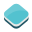

In [25]:
#make the soup
soup = BeautifulSoup(source, 'html')
print(soup.prettify())

In [26]:
#pick the second table. This one contains information about the soloriders.
#this only works when put in a different cell.Maybe because you'll have to wait till the previous line is loaded?
table_solo = soup.find_all('table')[2]
table_solo

IndexError: list index out of range

In [21]:
#find all the rows from this specific table
rows_solo = table_solo.findChildren('tr')

#convert each elements into a string to prevent an even more horrible mess
string_rows = []

for i in rows_solo:
    i = str(i)
    string_rows.append(i)
# print(string_rows[7]) #test

#convert the string+rows into a dataframe. Name the column "riders"
solo_riders = pd.DataFrame(string_rows)
solo_riders.columns=["riders"]
solo_riders.head()

#split the strings on </td> (this is removed)
solo_riders = solo_riders["riders"].str.split("</td>", expand = True)
solo_riders.head() #to check which columns you shoul delete in the next step

0                                   1   \
0  <tr><td colspan="6">                           <td>Start   
1            <tr><td>1)   <td style="vertical-align:top">26   
2            <tr><td>2)   <td style="vertical-align:top">18   
3            <tr><td>3)   <td style="vertical-align:top">16   
4            <tr><td>4)  <td style="vertical-align:top">133   

                                                  2   \
0                                       <td>Timing 1   
1  <td style="vertical-align:top;"><div style="mi...   
2  <td style="vertical-align:top;"><div style="mi...   
3  <td style="vertical-align:top;"><div style="mi...   
4  <td style="vertical-align:top;"><div style="mi...   

                                                  3             4   \
0                                       <td>Timing 2  <td>Timing 3   
1  <td style="vertical-align:top"><i aria-hidden=...   <td>Robison   
2  <td style="vertical-align:top"><i aria-hidden=...   <td>Robison   
3  <td style="vertical-align:top"><i aria-hidden=...  <td>Crawford   
4  <td style="vertical-align:top"><i aria-hidden=...    <td>Gebing   

                5                    6   \
0     <td>Timing 4         <td>Timing 5   
1        <td>Kevin  <td><b>Wed 8:00</b>   
2        <td>Jamie  <td><b>Wed 8:00</b>   
3  <td>Christopher  <td><b>Wed 8:00</b>   
4       <td>Pascal  <td><b>Wed 8:00</b>   

                                                  7   \
0                                       <td>Timing 6   
1  <td><span id="leaderboard_17478_1"><b>Wed 13:5...   
2  <td><span id="leaderboard_17477_1"><b>Wed 13:5...   
3         <td><span id="leaderboard_17475_1"></span>   
4  <td><span id="leaderboard_17494_1"><b>Wed 15:3...   

                                                  8   \
0                                       <td>Timing 7   
1  <td><span id="leaderboard_17478_2"><b>Thu 11:1...   
2  <td><span id="leaderboard_17477_2"><b>Thu 11:1...   
3  <td><span id="leaderboard_17475_2"><b>Thu 15:3...   
4  <td><span id="leaderboard_17494_2"><b>Thu 15:4...   

                                                  9   \
0                                       <td>Timing 8   
1  <td><span id="leaderboard_17478_3"><b>Thu 14:5...   
2  <td><span id="leaderboard_17477_3"><b>Thu 14:5...   
3  <td><span id="leaderboard_17475_3"><b>Thu 20:3...   
4  <td><span id="leaderboard_17494_3"><b>Thu 19:4...   

                                                  10  \
0                                       <td>Timing 9   
1  <td><span id="leaderboard_17478_4"><b>Thu 21:0...   
2  <td><span id="leaderboard_17477_4"><b>Thu 21:0...   
3  <td><span id="leaderboard_17475_4"><b>Fri 10:2...   
4  <td><span id="leaderboard_17494_4"><b>Fri 10:4...   

                                                  11  \
0                                         <td>Finish   
1  <td><span id="leaderboard_17478_5"><b>Fri 18:0...   
2  <td><span id="leaderboard_17477_5"><b>Fri 18:0...   
3         <td><span id="leaderboard_17475_5"></span>   
4         <td><span id="leaderboard_17494_5"></span>   

                                                  12  \
0                                              </tr>   
1  <td><span id="leaderboard_17478_6"><b>Sat 17:5...   
2  <td><span id="leaderboard_17477_6"><b>Sat 17:5...   
3  <td><span id="leaderboard_17475_6"><b>Sat 12:5...   
4  <td><span id="leaderboard_17494_6"><b>Sat 12:5...   

                                                  13  \
0                                               None   
1  <td><span id="leaderboard_17478_7"><b>Sun 5:50...   
2  <td><span id="leaderboard_17477_7"><b>Sun 5:51...   
3  <td><span id="leaderboard_17475_7"><b>Sat 18:2...   
4  <td><span id="leaderboard_17494_7"><b>Sat 18:1...   

                                                  14  \
0                                               None   
1  <td><span id="leaderboard_17478_8"><b>Sun 21:5...   
2  <td><span id="leaderboard_17477_8"><b>Sun 22:0...   
3  <td><span id="leaderboard_17475_8"><b>S

In [19]:
# MIGHT NEED CUSTOMIZATION inspect the head and decide which columns to drop. In this (2019) case: colnr 1; 2; 17
solo_riders.drop(solo_riders.columns[[1,2,17]], axis=1, inplace = True)
# print(solo_riders.head()) # to check if the dropping went right

#rename columns
solo_riders.columns=["Place", "MarsVenus","Lastname", "Firstname", "StartTiming", "Timing1", "Timing2", "Timing3", "Timing4","Timing5", "Timing6", "Timing7", "Timing8", "Timing9", "TimingFinish"]

#check which rows are empty/useless and you should drop in the next cell. You'll need to see all rows (display.max_rows).
# In this case the rows you want to delete are nr 0; 45, 84
pd.set_option('display.max_rows', solo_riders.shape[0]+1)
solo_riders

Place  \
0             <tr><td colspan="6">   
1                       <tr><td>1)   
2                       <tr><td>2)   
3                       <tr><td>3)   
4                       <tr><td>4)   
5                       <tr><td>5)   
6                       <tr><td>6)   
7                       <tr><td>7)   
8                       <tr><td>8)   
9                       <tr><td>9)   
10                     <tr><td>10)   
11                     <tr><td>11)   
12                     <tr><td>12)   
13                     <tr><td>13)   
14                     <tr><td>14)   
15                     <tr><td>15)   
16                     <tr><td>16)   
17                     <tr><td>17)   
18                     <tr><td>18)   
19                     <tr><td>19)   
20  <tr><td colspan="8"><b>DNF</b>   
21                       <tr><td>    
22                       <tr><td>    
23                       <tr><td>    
24                       <tr><td>    
25                       <tr><td>    
26                       <tr><td>    
27                       <tr><td>    
28  <tr><td colspan="8"><b>DNS</b>   
29                       <tr><td>    

                                            MarsVenus            Lastname  \
0                                        <td>Timing 2        <td>Timing 3   
1   <td style="vertical-align:top"><i aria-hidden=...         <td>Robison   
2   <td style="vertical-align:top"><i aria-hidden=...         <td>Robison   
3   <td style="vertical-align:top"><i aria-hidden=...        <td>Crawford   
4   <td style="vertical-align:top"><i aria-hidden=...          <td>Gebing   
5   <td style="vertical-align:top"><i aria-hidden=...          <td>Rutten   
6   <td style="vertical-align:top"><i aria-hidden=...           <td>Clark   
7   <td style="vertical-align:top"><i aria-hidden=...            <td>Hunt   
8   <td style="vertical-align:top"><i aria-hidden=...         <td>Alinski   
9   <td style="vertical-align:top"><i aria-hidden=...       <td>Barkowsky   
10  <td style="vertical-align:top"><i aria-hidden=...          <td>Visser   
11  <td style="vertical-align:top"><i aria-hidden=...          <td>Acampo   
12  <td style="vertical-align:top"><i aria-hidden=...          <td>Slavin   
13  <td style="vertical-align:top"><i aria-hidden=...          <td>Walker   
14  <td style="vertical-align:top"><i aria-hidden=...    <td>Van Ginneken   
15  <td style="vertical-align:top"><i aria-hidden=...         <td>Martens   
16  <td style="vertical-align:top"><i aria-hidden=...  <td>Minola-Violino   
17  <td style="vertical-align:top"><i aria-hidden=...          <td>Kramer   
18  <td style="vertical-align:top"><i aria-hidden=...      <td>Streunding   
19  <td style="vertical-align:top"><i aria-hidden=...        <td>Crawford   
20                                               None                None   
21  <td style="vertical-align:top"><i aria-hidden=...          <td>Dupouy   
22  <td style="vertical-align:top"><i aria-hidden=...        <td>Dehkordi   
23  <td style="vertical-align:top"><i aria-hidden=...            <td>Kelf   
24  <td style="vertical-align:top"><i aria-hidden=...         <td>de Jong   
25  <td style="vertical-align:top"><i aria-hidden=...       <td>Sällqvist   
26  <td style="vertical-align:top"><i aria-hidden=...           <td>Berry   
27  <td style="vertical-align:top"><i aria-hidden=...        <td>Skidmore   
28                                               None                None   
29  <td style="vertical-align:top"><i aria-hidden=...          <td>Pirani   

              Firstname          StartTiming  \
0          <td>Timing 4         <td>Timing 5   
1             <td>Kevin  <td><b>Wed 8:00</b>   
2             <td>Jamie  <td><b>Wed 8:00</b>   
3       <td>Christopher  <td><b>Wed 8:00</b>   
4            <td>Pascal  <td><b>Wed 8:00</b>   
5              <td>René  <td><b>Wed 8:00</b>   
6           <td>Gawaine  <td><b>Wed 8:00</b>   
7           <td>Richard  <td><b>Wed 8:00</b>   
8              <td>Marc  <td><

In [22]:
#CUSTOMIZE: drop useless ROWS
solo_riders = solo_riders.drop([0, 45, 84]).reset_index()
solo_riders.head()

KeyError: '[45 84] not found in axis'

In [ ]:
#extract the gender
gender = []

for row in solo_riders["MarsVenus"]:
    if 'mars' in row:
        gender.append('male')
    if 'venus' in row:
        gender.append('female')

# Add gender as a column to the solo_riders dataframe and drop the MarsVenus column and the automatically created index-column
solo_riders["Gender"] = gender        
solo_riders = solo_riders.drop(solo_riders[["MarsVenus", "index"]], axis = 1)
solo_riders.head()

In [ ]:
#CUSTOMIZE append columns with start date&time, and wether it's a solo or duo ride.
StartDate = datetime.datetime(2019, 5, 1, 8)
solo_riders.insert(0, 'Solo or Duo', 'Solo')
solo_riders.insert(0, 'StartDate', StartDate)

solo_riders.head()

##  Prepare the duo-table 2019
Prepare the duo-table, so the cleaning can then be done at the same time

In [ ]:
#grab the duo table
table_duo = soup.find_all('table')[3]
table_duo

In [ ]:
#grab the rows
rows_duo = table_duo.findChildren('tr')

#convert each elements into a string to prevent an even more horrible mess
string_rows = []

for i in rows_duo:
    i = str(i)
    string_rows.append(i)
print(string_rows[3])

In [ ]:
#convert the string+rows into a dataframe. Name the column "riders"
duo_riders = pd.DataFrame(string_rows)
duo_riders.columns=["riders"]
duo_riders.head()

#split the strings on </td>
duo_riders = duo_riders["riders"].str.split("</td>", expand = True)
duo_riders

In [ ]:
# CUSTOMIZE drop useless columns: colnr 1; 2; 17
duo_riders = duo_riders.drop(duo_riders.columns[[1,2,17]], axis=1)
duo_riders

#rename columns
duo_riders.columns=["Place", "MarsVenus","Lastname", "Firstname", "StartTiming", "Timing1", "Timing2", "Timing3", "Timing4","Timing5", "Timing6", "Timing7", "Timing8", "Timing9", "TimingFinish"]

#check which rows are empty/useless and you should drop in the next cell. 
duo_riders

In [ ]:
#CUSTOMIZE: drop useless ROWS
duo_riders = duo_riders.drop([0, 20, 28]).reset_index()
duo_riders.head()

In [ ]:
# NOTE 2019 pair-table doesnot make clear who is paird with who
#extract the gender
gender = []

for row in duo_riders["MarsVenus"]:
    if 'mars' in row:
        gender.append('male')
    if 'venus' in row:
        gender.append('female')

#Add gender as a column to the solo_riders dataframe and drop the MarsVenus column and the automatically created index-column
duo_riders["Gender"] = gender
duo_riders = duo_riders.drop(duo_riders[["MarsVenus", "index"]], axis = 1)
duo_riders

In [ ]:
#CUSTOMIZE append columns with the startdate (line 1) and whether it a duo or solo ride (line 2)
StartDate = datetime.datetime(2019, 5, 1, 8)
duo_riders.insert(0, 'Solo or Duo', 'Duo')
duo_riders.insert(0, 'StartDate', StartDate)
duo_riders.head()

In [ ]:
# glue solo and duo-riders together
all_riders = pd.concat([solo_riders, duo_riders]).reset_index()
all_riders = all_riders.drop(all_riders.columns[0], axis=1)
pd.set_option('display.max_rows', all_riders.shape[0]+1)
all_riders

In [ ]:
#set of patterns you want to delete from the columns:
del_patterns = ['<td>', '\)', '<b>', '</b>', '<span id="leaderboard_[\d][\d][\d][\d]_[\d][\d]*">', '</span>', '<tr>', '</tr>', None]

In [ ]:
all_riders = all_riders.replace(to_replace = del_patterns, value = '', regex = True)
all_riders.head()

In [ ]:
# add a column that tells you if the rider: finished on time (finisher); did not start (DNS) or did not finish (DNF)
# There are now white spaces when no place is assigned (DNS or DNF), and this overcomplicates stuff. Remove the white spaces.
all_riders['Place'] = all_riders['Place'].str.strip()

# create a list of the three conditions
conditions = [
    (all_riders["Place"] != ''), #finisher
    (all_riders["Place"] == '') & (all_riders['StartTiming'] != ''), #DNF
    (all_riders["Place"] == '') & (all_riders['StartTiming'] == '') #DNS
    ]

# create a list of the values we want to assign for each condition
values = ["Finisher", "DNF", "DNS"]

# create a new column and use np.select to assign values to it using our lists as arguments
all_riders['Status'] = np.select(conditions, values)

# display updated DataFrame
all_riders.head()

In [ ]:
# for prettiness sake, change the order of the columns a bit (place, first name, last name, gender, all timings)
all_riders = all_riders[["Place", "Firstname", "Lastname", "Gender", "Solo or Duo" , "StartDate", "Status", "StartTiming", "Timing1", "Timing2", "Timing3", "Timing4","Timing5", "Timing6", "Timing7", "Timing8", "Timing9", "TimingFinish"]]
all_riders.head()

In [ ]:
#CUSTOMIZE write to csv use the year in the name!
all_riders.to_csv('all_riders_2019.csv')

# PUT THIS INTO THE CODE!!!!!
#2019 ONLY: there is a mistake in the data, Neil Crawford gets assigned place 19, (and will therese later on be categorized as a 'finisher')
# He should get DNF. By removing 19, he will be recorded as DNF.

# solo_riders['Place'] = solo_riders['Place'].str.replace('19', '')
# solo_riders

# Do the same for edition 2020

In [ ]:
#CUSTOMIZE URL
url = 'https://ratn2020.legendstracking.com/#'

#set that you want to run the chrome headless (behind the scenes, in the background)
chrome_options = Options()
chrome_options.add_argument("--headless")

#insert absolute path of chrome driver
driver = webdriver.Chrome('C:/Users/jetsa/chromedriver.exe', options = chrome_options)
driver.get(url)

# Find and click the right button, using the tab's id
button = driver.find_element(By.ID, "leaderboard-icon")
button.click()

In [ ]:
#From here on you can start using BS4. I will now also see the html=code that became visible by clicking the button.
source = driver.page_source

#close the webdriver
driver.close()

In [ ]:
#make the soup
soup = BeautifulSoup(source, 'html')
print(soup.prettify())

In [ ]:
#MIGHT NEED CUSTOMIZATION, check if you find the right table when you choose table 2.
#The table should contain information about the timings of the soloriders.
#this only works when put in a different cell.Maybe because you'll have to wait till the previous line is loaded?
table_solo = soup.find_all('table')[2]
table_solo

In [ ]:
#find all the rows from this specific table
rows_solo = table_solo.findChildren('tr')

#convert each elements into a string to prevent an even more horrible mess
string_rows = []

for i in rows_solo:
    i = str(i)
    string_rows.append(i)
# print(string_rows[7]) #test

#convert the string+rows into a dataframe. Name the column "riders"
solo_riders = pd.DataFrame(string_rows)
solo_riders.columns=["riders"]
solo_riders.head()

#split the strings on </td> (this is removed)
solo_riders = solo_riders["riders"].str.split("</td>", expand = True)
solo_riders.head() #to check which columns you shoul delete in the next step

In [ ]:
# MIGHT NEED CUSTOMIZATION - inspect the head and decide which columns to drop. In this (2019) case: colnr 1; 2; 17
solo_riders.drop(solo_riders.columns[[1,2,17]], axis=1, inplace = True)
# print(solo_riders.head()) # to check if the dropping went right

#rename columns
solo_riders.columns=["Place", "MarsVenus","Lastname", "Firstname", "StartTiming", "Timing1", "Timing2", "Timing3", "Timing4","Timing5", "Timing6", "Timing7", "Timing8", "Timing9", "TimingFinish"]

#check which rows are empty/useless and you should drop in the next cell. You'll need to see all rows (display.max_rows).
# In this case the rows you want to delete are nr 0; 45, 84
pd.set_option('display.max_rows', solo_riders.shape[0]+1)
solo_riders

In [ ]:
#CUSTOMIZE: drop useless ROWS
solo_riders = solo_riders.drop([0, 61, 77]).reset_index()
solo_riders.head()

In [ ]:
#extract the gender
gender = []

for row in solo_riders["MarsVenus"]:
    if 'mars' in row:
        gender.append('male')
    if 'venus' in row:
        gender.append('female')

# Add gender as a column to the solo_riders dataframe and drop the MarsVenus column and the automatically created index-column
solo_riders["Gender"] = gender        
solo_riders = solo_riders.drop(solo_riders[["MarsVenus", "index"]], axis = 1)
solo_riders.head()

In [ ]:
#CUSTOMIZE append columns with start date&time, and wether it's a solo or duo ride.
StartDate = datetime.datetime(2020, 8, 29, 8)
solo_riders.insert(0, 'Solo or Duo', 'Solo')
solo_riders.insert(0, 'StartDate', StartDate)

solo_riders.head()

### Prepare the duo-table 2020

In [ ]:
#grab the duo table
table_duo = soup.find_all('table')[3]
table_duo

In [ ]:
#grab the rows
rows_duo = table_duo.findChildren('tr')

#convert each elements into a string to prevent an even more horrible mess
string_rows = []

for i in rows_duo:
    i = str(i)
    string_rows.append(i)
print(string_rows[3])

In [ ]:
#convert the string+rows into a dataframe. Name the column "riders"
duo_riders = pd.DataFrame(string_rows)
duo_riders.columns=["riders"]
duo_riders.head()

#split the strings on </td>
duo_riders = duo_riders["riders"].str.split("</td>", expand = True)
duo_riders

In [ ]:
# CUSTOMIZE drop useless columns: colnr 1; 2; 17
duo_riders = duo_riders.drop(duo_riders.columns[[1,2,17]], axis=1)
duo_riders

#rename columns
duo_riders.columns=["Place", "MarsVenus","Lastname", "Firstname", "StartTiming", "Timing1", "Timing2", "Timing3", "Timing4","Timing5", "Timing6", "Timing7", "Timing8", "Timing9", "TimingFinish"]

#check which rows are empty/useless and you should drop in the next cell. 
duo_riders

In [ ]:
#CUSTOMIZE: drop useless ROWS
duo_riders = duo_riders.drop([0, 4, 6]).reset_index()
duo_riders.head()

In [ ]:
#extract the gender
gender = []

for row in duo_riders["MarsVenus"]:
    if 'mars-double' in row:
        gender.append('male')
    if 'venus-double' in row:
        gender.append('female')
    if 'venus-mars' in row:
        gender.append('mixed')

#Add gender as a column to the solo_riders dataframe and drop the MarsVenus column and the automatically created index-column
duo_riders["Gender"] = gender
duo_riders = duo_riders.drop(duo_riders[["MarsVenus", "index"]], axis = 1)
duo_riders

In [ ]:
#CUSTOMIZE append columns with the startdate (line 1) and whether it a duo or solo ride (line 2)
StartDate = datetime.datetime(2020, 8, 29, 8)
duo_riders.insert(0, 'Solo or Duo', 'Duo')
duo_riders.insert(0, 'StartDate', StartDate)
duo_riders.head()

In [ ]:
# glue solo and duo-riders together
all_riders = pd.concat([solo_riders, duo_riders]).reset_index()
all_riders = all_riders.drop(all_riders.columns[0], axis=1)
pd.set_option('display.max_rows', all_riders.shape[0]+1)
all_riders

In [ ]:
#set of patterns you want to delete from the columns:
del_patterns = ['<td>', '\)', '<b>', '</b>', '<span id="leaderboard_[\d][\d][\d][\d][\d]*_[\d][\d]*">', '</span>', '<tr>', '</tr>', None]

In [ ]:
all_riders = all_riders.replace(to_replace = del_patterns, value = '', regex = True)
all_riders.head()

In [ ]:
# add a column that tells you if the rider: finished on time (finisher); did not start (DNS) or did not finish (DNF)
# There are now white spaces when no place is assigned (DNS or DNF), and this overcomplicates stuff. Remove the white spaces.
all_riders['Place'] = all_riders['Place'].str.strip()

# create a list of the three conditions
conditions = [
    (all_riders["Place"] != ''), #finisher
    (all_riders["Place"] == '') & (all_riders['StartTiming'] != ''), #DNF
    (all_riders["Place"] == '') & (all_riders['StartTiming'] == '') #DNS
    ]

# create a list of the values we want to assign for each condition
values = ["Finisher", "DNF", "DNS"]

# create a new column and use np.select to assign values to it using our lists as arguments
all_riders['Status'] = np.select(conditions, values)

# display updated DataFrame
all_riders.head()

In [ ]:
# for prettiness sake, change the order of the columns a bit (place, first name, last name, gender, all timings)
all_riders = all_riders[["Place", "Firstname", "Lastname", "Gender", "Solo or Duo" , "StartDate", "Status", "StartTiming", "Timing1", "Timing2", "Timing3", "Timing4","Timing5", "Timing6", "Timing7", "Timing8", "Timing9", "TimingFinish"]]
all_riders.head()

In [ ]:
#CUSTOMIZE write to csv use the year in the name!
all_riders.to_csv('all_riders_2020.csv')

# Do the same for 2021

In [ ]:
#CUSTOMIZE URL
url = 'https://ratn2021.legendstracking.com/#'

#set that you want to run the chrome headless (behind the scenes, in the background)
chrome_options = Options()
chrome_options.add_argument("--headless")

#insert absolute path of chrome driver
driver = webdriver.Chrome('C:/Users/jetsa/chromedriver.exe', options = chrome_options)
driver.get(url)

# Find and click the right button, using the tab's id
button = driver.find_element(By.ID, "leaderboard-icon")
button.click()

In [ ]:
#From here on you can start using BS4. I will now also see the html=code that became visible by clicking the button.
source = driver.page_source

#close the webdriver
driver.close()

In [ ]:
#make the soup
soup = BeautifulSoup(source, 'html')
print(soup.prettify())

In [ ]:
#MIGHT NEED CUSTOMIZATION 
# check in the output below if you find the right table when you choose table 2.
#The table should contain information about the timings of the soloriders.
#this only works when put in a different cell.Maybe because you'll have to wait till the previous line is loaded?
table_solo = soup.find_all('table')[2]
table_solo

In [ ]:
#find all the rows from this specific table
rows_solo = table_solo.findChildren('tr')

#convert each elements into a string to prevent an even more horrible mess
string_rows = []

for i in rows_solo:
    i = str(i)
    string_rows.append(i)
# print(string_rows[7]) #test

#convert the string+rows into a dataframe. Name the column "riders"
solo_riders = pd.DataFrame(string_rows)
solo_riders.columns=["riders"]
solo_riders.head()

#split the strings on </td> (this is removed)
solo_riders = solo_riders["riders"].str.split("</td>", expand = True)
solo_riders.head() #to check which columns you shoul delete in the next step

In [ ]:
# MIGHT NEED CUSTOMIZATION - inspect the head and decide which columns to drop. In this (2019) case: colnr 1; 2; 17
solo_riders.drop(solo_riders.columns[[1,2,17]], axis=1, inplace = True)
# print(solo_riders.head()) # to check if the dropping went right

#rename columns
solo_riders.columns=["Place", "MarsVenus","Lastname", "Firstname", "StartTiming", "Timing1", "Timing2", "Timing3", "Timing4","Timing5", "Timing6", "Timing7", "Timing8", "Timing9", "TimingFinish"]

#check which rows are empty/useless and you should drop in the next cell. You'll need to see all rows (display.max_rows).
# In this case the rows you want to delete are nr 0; 45, 84
pd.set_option('display.max_rows', solo_riders.shape[0]+1)
solo_riders

In [ ]:
#CUSTOMIZE: drop useless ROWS (basically the rows that have a None in LastName-column)
solo_riders = solo_riders.drop([0, 32, 61]).reset_index()
solo_riders.head()

#extract the gender
gender = []

for row in solo_riders["MarsVenus"]:
    if 'mars' in row:
        gender.append('male')
    if 'venus' in row:
        gender.append('female')

# Add gender as a column to the solo_riders dataframe and drop the MarsVenus column and the automatically created index-column
solo_riders["Gender"] = gender        
solo_riders = solo_riders.drop(solo_riders[["MarsVenus", "index"]], axis = 1)
solo_riders.head()

In [ ]:
#CUSTOMIZE append columns with start date&time, and wether it's a solo or duo ride.
StartDate = 2021 #NOTE the riders started at different dates and times because of corona
solo_riders.insert(0, 'Solo or Duo', 'Solo')
solo_riders.insert(0, 'StartDate', StartDate)

solo_riders.head()

### Duo-riders 2021

In [ ]:
#grab the duo table
table_duo = soup.find_all('table')[3]
table_duo

In [ ]:
#grab the rows
rows_duo = table_duo.findChildren('tr')

#convert each elements into a string to prevent an even more horrible mess
string_rows = []

for i in rows_duo:
    i = str(i)
    string_rows.append(i)
print(string_rows[1])

In [ ]:
#convert the string+rows into a dataframe. Name the column "riders"
duo_riders = pd.DataFrame(string_rows)
duo_riders.columns=["riders"]
duo_riders.head()

#split the strings on </td>
duo_riders = duo_riders["riders"].str.split("</td>", expand = True)
duo_riders

In [ ]:
# CUSTOMIZE drop useless columns: colnr 1; 2; 17
duo_riders = duo_riders.drop(duo_riders.columns[[1,2,17]], axis=1)
duo_riders

#rename columns
duo_riders.columns=["Place", "MarsVenus","Lastname", "Firstname", "StartTiming", "Timing1", "Timing2", "Timing3", "Timing4","Timing5", "Timing6", "Timing7", "Timing8", "Timing9", "TimingFinish"]

#check which rows are empty/useless and you should drop in the next cell. 
duo_riders

In [ ]:
#CUSTOMIZE: drop useless ROWS
duo_riders = duo_riders.drop([0, 3]).reset_index()
duo_riders.head()

In [ ]:
#extract the gender
gender = []

for row in duo_riders["MarsVenus"]:
    if 'mars-double' in row:
        gender.append('male')
    if 'venus-double' in row:
        gender.append('female')
    if 'venus-mars' in row:
        gender.append('mixed')

#Add gender as a column to the solo_riders dataframe and drop the MarsVenus column and the automatically created index-column
duo_riders["Gender"] = gender
duo_riders = duo_riders.drop(duo_riders[["MarsVenus", "index"]], axis = 1)
duo_riders

In [ ]:
#CUSTOMIZE append columns with the startdate (line 1) and whether it a duo or solo ride (line 2)
StartDate = 2021 #NOTE in 2021 the riders started on different dates and times because of corona
duo_riders.insert(0, 'Solo or Duo', 'Duo')
duo_riders.insert(0, 'StartDate', StartDate)
duo_riders.head()

In [ ]:
# glue solo and duo-riders together
all_riders = pd.concat([solo_riders, duo_riders]).reset_index()
all_riders = all_riders.drop(all_riders.columns[0], axis=1)
pd.set_option('display.max_rows', all_riders.shape[0]+1)
all_riders

In [ ]:
# CUSTOMIZE: set of patterns you want to delete from the columns:
del_patterns = ['<td>', '\)', '<b>', '</b>', '<span id="leaderboard_[\d][\d][\d][\d][\d]*_[\d][\d]*">', '</span>', '<tr>', '</tr>', None]

all_riders = all_riders.replace(to_replace = del_patterns, value = '', regex = True)
all_riders # check if the cleaning went right

In [ ]:
# add a column that tells you if the rider: finished on time (finisher); did not start (DNS) or did not finish (DNF)
# There are now white spaces when no place is assigned (DNS or DNF), and this overcomplicates stuff. Remove the white spaces.
all_riders['Place'] = all_riders['Place'].str.strip()

# create a list of the three conditions
conditions = [
    (all_riders["Place"] != ''), #finisher
    (all_riders["Place"] == '') & (all_riders['StartTiming'] != ''), #DNF
    (all_riders["Place"] == '') & (all_riders['StartTiming'] == '') #DNS
    ]

# create a list of the values we want to assign for each condition
values = ["Finisher", "DNF", "DNS"]

# create a new column and use np.select to assign values to it using our lists as arguments
all_riders['Status'] = np.select(conditions, values)

# display updated DataFrame
all_riders.head()

In [ ]:
# for prettiness sake, change the order of the columns a bit (place, first name, last name, gender, all timings)
all_riders = all_riders[["Place", "Firstname", "Lastname", "Gender", "Solo or Duo" , "StartDate", "Status", "StartTiming", "Timing1", "Timing2", "Timing3", "Timing4","Timing5", "Timing6", "Timing7", "Timing8", "Timing9", "TimingFinish"]]
all_riders

In [ ]:
#CUSTOMIZE write to csv use the year in the name!
all_riders.to_csv('all_riders_2021.csv')